## 05 - The Many Variables & The Spurious Waffles

#### Imports

In [1]:
# ruff: noqa: F405
from init_notebook import *

%config InlineBackend.figure_formats = ['svg']

Module aliases imported by init_notebook.py:
--------------------------------------------
import numpy as np

import pandas as pd

import statsmodels.formula.api as smf

import pymc as pm

import xarray as xr

import arviz as az

import utils as utils

import seaborn as sns

from scipy import stats as stats

from matplotlib import pyplot as plt

Watermark:
----------
Last updated: 2025-02-15T03:41:26.907013+04:00

Python implementation: CPython
Python version       : 3.12.8
IPython version      : 8.32.0

Compiler    : Clang 18.1.8 
OS          : Darwin
Release     : 24.3.0
Machine     : arm64
Processor   : arm
CPU cores   : 8
Architecture: 64bit

seaborn    : 0.13.2
matplotlib : 3.10.0
numpy      : 1.26.4
xarray     : 2025.1.2
scipy      : 1.12.0
arviz      : 0.20.0
statsmodels: 0.14.4
pymc       : 5.20.1
pandas     : 2.2.3
watermark  : 2.5.0



#### Introduction

One of the most reliable sources of waffles in North America, if not the entire world, is a Waffle House diner. Waffle House is nearly always open, even just after a hurricane. Most diners invest in disaster preparedness, including having their own electrical generators. As a consequence, the United States’ disaster relief agency (FEMA) informally uses Waffle House as an index of disaster severity. If the Waffle House is closed, that’s a serious event.

It is ironic then that steadfast Waffle House is associated with the nation’s highest divorce rates. States with many Waffle Houses per person, like Georgia and Alabama, also have some of the highest divorce rates in the United States. The lowest divorce rates are found where there are zero Waffle Houses. Could always-available waffles and hash brown potatoes put marriage at risk?

Probably not. This is an example of a misleading correlation. No one thinks there is any plausible mechanism by which Waffle House diners make divorce more likely. Instead, when we see a correlation of this kind, we immediately start asking about other variables that are really driving the relationship between waffles and divorce. In this case, Waffle House began in Georgia in the year 1955. Over time, the diners spread across the Southern United States, remaining largely within it. So Waffle House is associated with the South. Divorce is not a uniquely Southern institution, but the Southern United States has some of the highest divorce rates in the nation. So it’s probably just an accident of history that Waffle House and high divorce rates both occur in the South.

Such accidents are commonplace. It is not surprising that Waffle House is correlated with divorce, because correlation in general is not surprising. In large data sets, every pair of variables has a statistically discernible non-zero correlation. But since most correlations do not indicate causal relationships, we need tools for distinguishing mere association from evidence of causation. This is why so much effort is devoted to **multiple regression**, using more than one predictor variable to simultaneously model an outcome. Reasons given for multiple regression models include:

1) Statistical “control” for **confounds**. A confound is something that misleads us about a causal influence—there will be a more precise definition in the next chapter. The spurious waffles and divorce correlation is one type of confound, where southern-ness makes a variable with no real importance (Waffle House density) appear to be important. But confounds are diverse. They can hide important effects just as easily as they can produce false ones.
2) **Multiple and complex causation**. A phenomenon may arise from multiple simultaneous causes, and causes can cascade in complex ways. And since one cause can hide another, they must be measured simultaneously.
3) **Interactions**. The importance of one variable may depend upon another. For example, plants benefit from both light and water. But in the absence of either, the other is no benefit at all. Such interactions occur very often. Effective inference about one variable will often depend upon consideration of others.

In this chapter, we begin to deal with the first of these two, using multiple regression to deal with simple confounds and to take multiple measurements of association. You’ll see how to include any arbitrary number of *main effects* in your linear model of the Gaussian mean. These main effects are additive combinations of variables, the simplest type of multiple variable model. We’ll focus on two valuable things these models can help us with: (1) revealing *spurious* correlations like the Waffle House correlation with divorce and (2) revealing important correlations that may be masked by unrevealed correlations with other variables. Along the way, you’ll meet **categorical variables**, which require special handling compared to continuous variables.

However, multiple regression can be worse than useless, if we don’t know how to use it. Just adding variables to a model can do a lot of damage. In this chapter, we’ll begin to think formally about **causal inference** and introduce graphical causal models as a way to design and interpret regression models. The next chapter continues on this theme, describing some serious and common dangers of adding predictor variables, ending with a unifying framework for understanding the examples in both this chapter and the next.

**Causal inference**. Despite its central importance, there is no unified approach to causal inference yet in the sciences. There are even people who argue that cause does not really exist; it’s just a psychological illusion. And in complex dynamical systems, everything seems to cause everything else. “Cause” loses intuitive value. About one thing, however, there is general agreement: Causal inference always depends upon unverifiable assumptions. Another way to say this is that it’s always possible to imagine some way in which your inference about cause is mistaken, no matter how careful the design or analysis. A lot can be accomplished, despite this barrier.

#### Spurious Association

Let’s leave waffles behind, at least for the moment. An example that is easier to understand is the correlation between **divorce rate and marriage rate**. The rate at which adults marry is a great predictor of divorce rate, as seen in the plots below. But does marriage cause divorce? In a trivial sense it obviously does: One cannot get a divorce without first getting married. But there’s no reason high marriage rate must cause more divorce. It’s easy to imagine high marriage rate indicating high cultural valuation of marriage and therefore being associated with low divorce rate.

Another predictor associated with divorce is the **median age at marriage**, also displayed in a plot below. Age at marriage is also a good predictor of divorce rate — higher age at marriage predicts less divorce. But there is no reason this has to be causal, either, unless age at marriage is very late and the spouses do not live long enough to get a divorce.

Let’s load these data and standardize the variables of interest:

In [2]:
# load data
d = pd.read_csv("data/WaffleDivorce.csv", sep=';')

# standardize variables
d['D'] = utils.standardize(d.Divorce)
d['M'] = utils.standardize(d.Marriage)
d['A'] = utils.standardize(d.MedianAgeMarriage)

Median age of marriage and divorce rate linear regression model:

$$
\begin{align*}
  D_i &\sim \text{Normal}(\mu_i,\sigma) \\
  \mu_i &= \alpha + \beta_A A_{i} \\
  \alpha &\sim \text{Normal}(0, 0.2) \\
  \beta_A &\sim \text{Normal}(0,0.5) \\
  \sigma &\sim \text{Exponential}(1)
\end{align*}
$$

$D_i$ is the standardized (zero centered, standard deviation one) divorce rate for State $i$, and $A_i$ is State $i$’s standardized median age at marriage. 

What about those priors? Since the outcome and the predictor are both standardized, the intercept $α$ should end up very close to zero. What does the prior slope $β_A$ imply? If $β_A =1$, that would imply that a change of one standard deviation in age at marriage is associated likewise with a change of one standard deviation in divorce. To know whether or not that is a strong relationship, you need to know how big a standard deviation of age at marriage is:

In [3]:
d.MedianAgeMarriage.std()

1.2436303013880823

So when $β_A =1$, a change of 1.2 years in median age at marriage is associated with a full standard deviation change in the outcome variable. That seems like an insanely strong relationship. The prior above thinks that only 5% of plausible slopes are more extreme than 1. We’ll simulate from these priors in a moment, so you can see how they look in the outcome space.

To compute the approximate posterior, there are no new code tricks or techniques here. But I’ll add comments to help explain the mass of code to follow.

In [4]:
with pm.Model() as m5_1:
    A = pm.ConstantData("A", d.A, dims="obs_id")
    a = pm.Normal("a", mu=0, sigma=0.2)
    bA = pm.Normal("bA", mu=0, sigma=0.5)
    sigma = pm.Exponential("sigma", 1)
    mu = pm.Deterministic('mu', a + bA * A, dims="obs_id")
    D = pm.Normal("D", mu=mu, sigma=sigma, observed=d.D, dims="obs_id")

    # Prior predictive sample with -2 to 2 standardized median age marriage range
    pm.set_data({"A": np.linspace(-2,2)})
    idata_m5_1 = pm.sample_prior_predictive(var_names=['a', 'bA', 'sigma', 'mu', 'D'])    
    
    pm.set_data({"A": d.A})
    custom_step_m5_1 = utils.QuadraticApproximation([a, bA, sigma], m5_1)
    idata_m5_1.extend(pm.sample(draws=10_000, chains=1, tune=0, step=custom_step_m5_1, progressbar=False))
    
    # Posterior predictive sample with -3 to 3.2 standardized median age marriage range
    pm.set_data({"A": np.linspace(-3, 3.2, 30)})
    pm.sample_posterior_predictive(
        idata_m5_1,
        var_names=["D", "mu"],
        predictions=True,
        extend_inferencedata=True,
        progressbar=False
    )  

Sampling: [D, a, bA, sigma]
Sequential sampling (1 chains in 1 job)
QuadraticApproximation: [a, bA, sigma]
Sampling 1 chain for 0 tune and 10_000 draw iterations (0 + 10_000 draws total) took 0 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Sampling: [D]


To simulate from the priors, I have ran the PyMC function `pm.sample_prior_predictive`. I’ll plot the lines over the range of 2 standard deviations for both the outcome and predictor. That’ll cover most of the possible range of both variables.

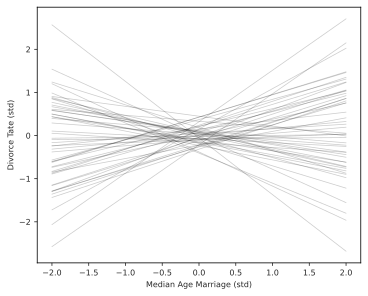

In [5]:
plt.plot(np.linspace(-2,2), az.extract(idata_m5_1, 'prior').mu[:,:50], 'k', alpha=0.2)
plt.xlabel('Median Age Marriage (std)')
plt.ylabel('Divorce Tate (std)');

Plausible regression lines implied by the priors in `m5_1`. These are weakly informative priors in that they allow some implusibly strong relationships but generally bound the lines to possible ranges of the variables.

You may wish to try some vaguer, flatter priors and see how quickly the prior regression lines become ridiculous.

Now for the posterior predictions. The procedure is exactly like earlier: compute `sample_posterior_predictive` and then summarize the $\mu$ with its mean of and HDI.

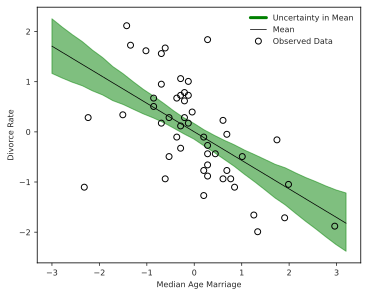

In [19]:
A_seq = np.linspace(-3, 3.2, 30)

fig, ax = plt.subplots()

hdi = az.plot_hdi(A_seq, idata_m5_1.predictions["mu"], 
                     hdi_prob=0.89, smooth=False, color='green') 

mean_line, = ax.plot(A_seq, idata_m5_1.predictions["mu"].mean(axis=1)[0], 'k', label='Mean')
obs_data, = ax.plot(d.A, d.D, 'o', fillstyle='none', label='Observed Data', color='k')

hdi_patch = plt.Line2D([0], [1], color='green', lw=3, label="Uncertainty in Mean")

ax.set(xlabel="Median Age Marriage",
       ylabel="Divorce Rate")

ax.legend(handles=[hdi_patch, mean_line, obs_data]);

In [20]:
az.summary(idata_m5_1, var_names=['~mu'], kind='stats', hdi_prob=0.89)

,mean,sd,hdi_5.5%,hdi_94.5%
a,0.000,0.097,-0.148,0.164
bA,-0.569,0.110,-0.742,-0.393
sigma,0.796,0.079,0.665,0.917


In [21]:
with pm.Model() as m5_2:
    M = pm.ConstantData("M", d.M, dims="obs_id")
    a = pm.Normal("a", mu=0, sigma=0.2)
    bM = pm.Normal("bM", mu=0, sigma=0.5)
    sigma = pm.Exponential("sigma", 1)
    mu = pm.Deterministic('mu', a + bM * M, dims="obs_id")
    D = pm.Normal("D", mu=mu, sigma=sigma, observed=d.D, dims="obs_id")

    idata_m5_2 = pm.sample_prior_predictive()    
    
    custom_step_m5_2 = utils.QuadraticApproximation([a, bM, sigma], m5_2)
    idata_m5_2.extend(pm.sample(draws=10_000, chains=1, tune=0, step=custom_step_m5_2, progressbar=False))
    
    pm.sample_posterior_predictive(
        idata_m5_2,
        var_names=["D", "mu"],
        predictions=True,
        extend_inferencedata=True,
        progressbar=False
    )  

Sampling: [D, a, bM, sigma]
Sequential sampling (1 chains in 1 job)
QuadraticApproximation: [a, bM, sigma]
Sampling 1 chain for 0 tune and 10_000 draw iterations (0 + 10_000 draws total) took 0 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Sampling: [D]


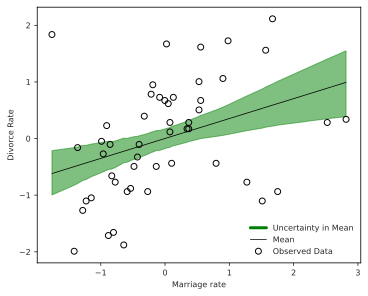

In [23]:
fig, ax = plt.subplots()

hdi = az.plot_hdi(d.M, idata_m5_2.predictions["mu"], 
                     hdi_prob=0.89, smooth=False, color='green') 

mean_line, = ax.plot(d.M, idata_m5_2.predictions["mu"].mean(axis=1)[0], 'k', label='Mean')
obs_data, = ax.plot(d.M, d.D, 'o', fillstyle='none', label='Observed Data', color='k')

hdi_patch = plt.Line2D([0], [1], color='green', lw=3, label="Uncertainty in Mean")

ax.set(xlabel="Marriage rate",
       ylabel="Divorce Rate")

ax.legend(handles=[hdi_patch, mean_line, obs_data]);

As you can see in the figure, this relationship isn’t as strong as the previous one.

Divorce rate is associated with both marriage rate and median age at marriage. Both predictor variables are standardized in this example. The average marriage rate across States is 20 per 1000 adults, and the average median age at marriage is 26 years.